# Cluster Analysis Example

As guidance for this work, I refer largely to an Email Clustering Thesis https://www.scribd.com/document/21970433/Email-clustering-algorithm, and a pipline referred to in the Wikipedia article on Text Clustering.

This notebook starts off by taking example text data and does the following:
* Cleans data (Removes stopwords, stems, etc.)
* Tokenizes words, might TF-IDF it
* Performs Dimension Reduction (PCA algorithm)
* Performs Cluster Analysis

In this notebook, a number of clustering algorithms are presented such as K-Means, MeanShift, and finally we use a Non-negative Matrix Factorisation technique for topic identification. The purpose of comparing algorithms isn't necessarily to rule them out, instead it's more about trying to get a working example of each one.

For the example dataset used dimension reduction isn't really needed as the size of the dataset is unlikely to be computationally intensive, however it sets the standard for any future use of larger datasets.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import nltk

from nltk.collocations import *
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

% matplotlib inline

## Data used

For the purposes of this example, we'll just use Sklearn's 20 newsgroups dataset http://scikit-learn.org/stable/datasets/twenty_newsgroups.html#newsgroups

In [3]:
from sklearn.datasets import fetch_20newsgroups

In [4]:
categories = [
    'talk.politics.mideast',
    'rec.motorcycles',
]

remove = ('headers', 'footers', 'quotes')

In [5]:
data_train = fetch_20newsgroups(subset='train', categories=categories,
                               random_state=42,
                               remove=remove)

In [6]:
data_test = fetch_20newsgroups(subset='test', categories=categories,
                               random_state=42,
                               remove=remove)

In [7]:
train = data_train.data
train[:4]

[u'\n\nYep...I think it\'s the only CB750 with a 630 chain.\nAfter 14 years, it\'s finally stretching into the "replace" zone.\n\n\n<Sigh> I know .... I know.',
 u": \n: While you brought up the separate question of Israel's unjustified\n: policies and practices, I am still unclear about your reaction to\n: the practices and polocies reflected in the article above.\n: \n: Tim\n\nNot a separate question Mr. Clock. It is deceiving to judge the \nresistance movement out of the context of the occupation.",
 u'\n\n\tI\'m not sure that\'s true.  Let me rephrase; "You can file a complaint\n which will bring the person into court."  As I understand it, a\n "citizens arrest" does not have to be the physical detention of\n the person.\n\n Better now?',
 u'\nI bought my Moto Guzzi from a Univ of Va grad student in Charlottesville\nlast spring.\n\n\t     Mark Cervi, cervi@oasys.dt.navy.mil, (w) 410-267-2147\n\t\t DoD #0603  MGNOC #12998  \'87 Moto Guzzi SP-II\n      "What kinda bikes that?" A Moto

### Data cleaning

As we can see from the above, the data given is quite messy and has a formatting, punctuation, stopwords, etc that we'd like to parse out before running our model.

In [8]:
df = pd.DataFrame({'col':train})
df.head()

,col
0,\n\nYep...I think it's the only CB750 with a 6...
1,: \n: While you brought up the separate questi...
2,\n\n\tI'm not sure that's true. Let me rephra...
3,\nI bought my Moto Guzzi from a Univ of Va gra...
4,I was just wondering if there were any law off...


In [9]:
df['col'] = df['col'].str.lower().str.split()

In [10]:
# Remove stopwords from text using NLTK.
stop = stopwords.words('english')
df['col'] = df['col'].apply(lambda x: [item for item in x if item not in stop])

In [11]:
# Stem words for better model performance
stemmer = SnowballStemmer("english")
df['col'] = df['col'].apply(lambda x: [stemmer.stem(y) for y in x])

In [12]:
df.head()

,col
0,"[yep...i, think, it, cb750, 630, chain., 14, y..."
1,"[:, :, brought, separ, question, israel, unjus..."
2,"[i'm, sure, that, true., let, rephrase;, ""you,..."
3,"[bought, moto, guzzi, univ, va, grad, student,..."
4,"[wonder, law, offic, read, this., sever, quest..."


In [13]:
# df.to_csv('clean_news_data.csv')

## Export to CSV for further cleaning in Excel

In [14]:
df = pd.read_csv('./data/clean_news_data.csv', usecols=[1],
                           names=['text'],
                           header=0)

In [15]:
df = df.dropna()
df['text'] = df['text'].str.replace(r'\W', ' ', case = False)
df['text'] = df['text'].str.replace(r'[.,?<>-]', '')

In [16]:
df.head()

,text
0,brought separ question israel unjustifi ...
1,uim sure that true let rephrase yo file compl...
2,bought moto guzzi univ va grad student charlot...
3,wonder law offic read this sever question woul...
4,theori holler kill spirit criminal nazi armeni...


The head of the dataframe now shows that the text has been cleaned pretty well! There are no clear stopwords, symbols and words have stemmed, eg Officer -> Offic etc.

In [17]:
vectorizer = TfidfVectorizer(max_df=0.9,
                            stop_words='english')
X = vectorizer.fit_transform(df['text'])

In [18]:
X

<1131x17465 sparse matrix of type '<type 'numpy.float64'>'
	with 82503 stored elements in Compressed Sparse Row format>

In [19]:
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [20]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print


print("\n")
print("Prediction")

Y = vectorizer.transform(["This Motorbike has the best chain"])
prediction = model.predict(Y)
print(prediction)

Y = vectorizer.transform(["Turkey is close to Israel"])
prediction = model.predict(Y)
print(prediction)

Top terms per cluster:
Cluster 0:  bike  ride  like  know  udont  uim  think  make  motorcycl  say
Cluster 1:  israel  armenian  isra  arab  jew  peopl  turkish  kill  state  said


Prediction
[0]
[1]


In [21]:
k_means_labels = model.labels_
k_means_labels

array([1, 0, 0, ..., 0, 0, 0])

In [22]:
unique, counts = np.unique(k_means_labels, return_counts=True)
dict(zip(unique, counts))

{0: 786, 1: 345}

In [27]:
df['label'] = k_means_labels

,text,label
0,brought separ question israel unjustifi ...,1
1,uim sure that true let rephrase yo file compl...,0
2,bought moto guzzi univ va grad student charlot...,0
3,wonder law offic read this sever question woul...,0
4,theori holler kill spirit criminal nazi armeni...,1


In [28]:
def cos_distance(u, v): 
    """
    Function to take two documents, calculate the cosine distance between them
    """ 
    return np.dot(u,v) / (sqrt(np.dot(u,u)) * sqrt(np.dot(v,v)))

In [29]:
sent1 = 
sent2 = "foo bar bar black sheep"
sent3 = "this is a sentence"

In [ ]:
averages = []
def calc_avg(**args):
    for i in unique:
        counts = 
        for x in doc:
            cluster = data[data['label'] == i]
            u = cluster.iloc[i]
            v = cluster.iloc[i + 1]
            counts 

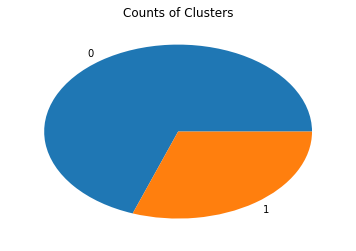

In [24]:
plt.pie(counts, labels=unique)
plt.title('Counts of Clusters')
plt.show()

## MeanShift Clustering

MeanShift clustering is another centriod based clustering alogrithim that works in a similar way to the above K-Means. The advantage of Meanshift is that you don't have to specify the number of clusters prior to analysis. This is has a disctinct advantage over K-Means as when analysing general KAs, we're not sure how many natural clusters there are.

In [22]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [23]:
bandwidth = estimate_bandwidth(X.toarray(), quantile=0.2) ## Do PCA or other dimension reduction for real data.

In [24]:
mean_shift_model = MeanShift(bandwidth=bandwidth, bin_seeding=True)

In [25]:
mean_shift_model.fit(X.toarray())

MeanShift(bandwidth=1.3979169548387635, bin_seeding=True, cluster_all=True,
     min_bin_freq=1, n_jobs=1, seeds=None)

In [26]:
labels = mean_shift_model.labels_
cluster_centers = mean_shift_model.cluster_centers_

labels_unique = np.unique(labels)
n_clusters = len(labels_unique)

In [27]:
print n_clusters

1


MeanShift at the moment, doesn't look fully helpful if it's only yielding a single cluster... Might need work.

# Spectral Clustering

In [28]:
from sklearn.cluster import SpectralClustering

In [29]:
clust = SpectralClustering(n_clusters=2)

In [30]:
result = clust.fit_predict(X)

In [31]:
result

array([0, 0, 0, ..., 0, 0, 0])

# Dimension Scaling for Visualisation

In [51]:
from sklearn.decomposition import PCA

In [52]:
pca = PCA(n_components=2, random_state=1)
result = pca.fit_transform(X.toarray())

In [53]:
x, y = result[:, 0], result[:, 1]

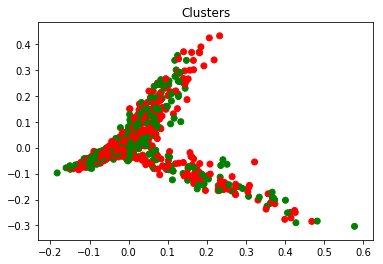

In [54]:
plt.scatter(x, y, c=['red', 'green'])
plt.title('Clusters')
plt.show()

In [46]:
from sklearn.manifold import MDS

In [47]:
mds = MDS(n_components=2, random_state=1)
result_mds = mds.fit_transform(X.toarray())

In [48]:
x, y = result_mds[:, 0], result_mds[:, 1]

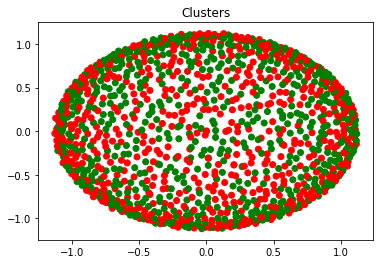

In [49]:
plt.scatter(x, y, c=['red', 'green'])
plt.title('Clusters')
plt.show()

## Non-negative Matrix Factorisation

As NMF is typically a dimension reduction technique in itself, the methodology for this algorithim is going to be slightly different. We'll do the following:

* Cleans data (Removes stopwords, stems, etc.)
* Tokenizes words, might TF-IDF it
* Perform NMF on tokenized vector.

# Model Performance

Measuring the performance of a model is typically quite trival. However, since the model used on actual data will have no labels reflecting the true topic or cluster, we're trying to measure something that doesn't really exist.

Having absolutely no labelled data adds a complexity in choosing the model, and really only leaves us with The Silhouette Coefficient or the Calinski-Harabaz index. Both are metrics where evaluation is performed on the model itself without ground label truths (labelled data). In this analysis, we'll be using the Silhouette Coefficient.

The Silhouette Coefficient can is a measure of how well defined the clusters are, from this we can infer as to whether there are seperate clusters, or whether the clusters are overlapping. It's calculated by:

\begin{align}
s = \frac{b-a}{\max (b)}
\end{align}

Where:
* a: The mean distance between a sample and all other points in the same class.
* b: The mean distance between a sample and all other points in the next nearest cluster.

### Interpreting the Performance

The Silhouette Coefficient is range bound to -1 to +1, where a high value indicates the object is well matched to its own cluster. So we are looking to maximise the Sillhouette Coefficient. 

In [38]:
from sklearn import metrics

In [39]:
metrics.silhouette_score(X, k_means_labels, metric='euclidean')

0.0055683321625466841